In [5]:
library("DEP")
library("dplyr")
library("tidyr")
library("purrr")
library("ggplot2")
library("SummarizedExperiment")
library('hexbin')
library('rcompanion')
library('ggfortify')
library('devtools')

class: SummarizedExperiment 
dim: 1342 17 
metadata(0):
assays(1): ''
rownames(1342): 10010 10011 ... 9956 9997
rowData names(3): ClusterID name ID
colnames(17): control_1 control_2 ... treatment_7 treatment_8
colData names(4): label ID condition replicate

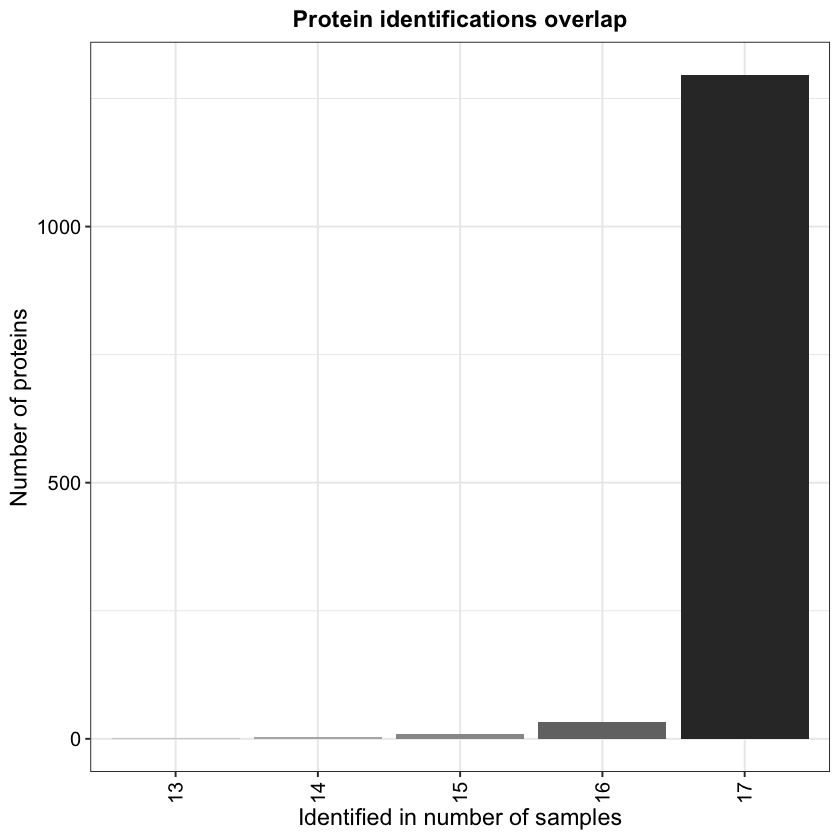

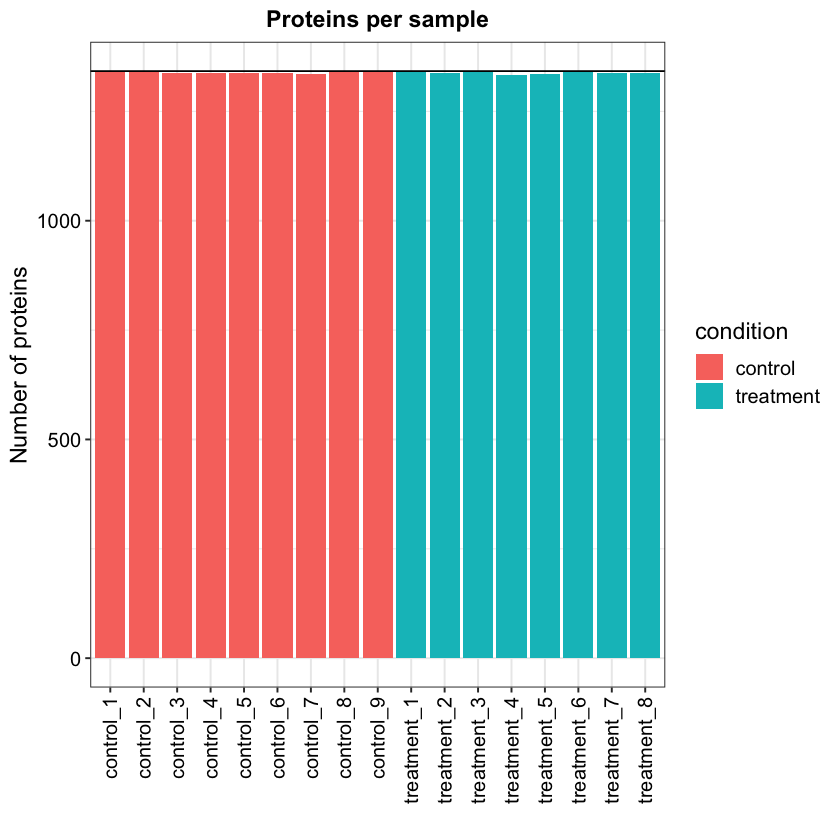

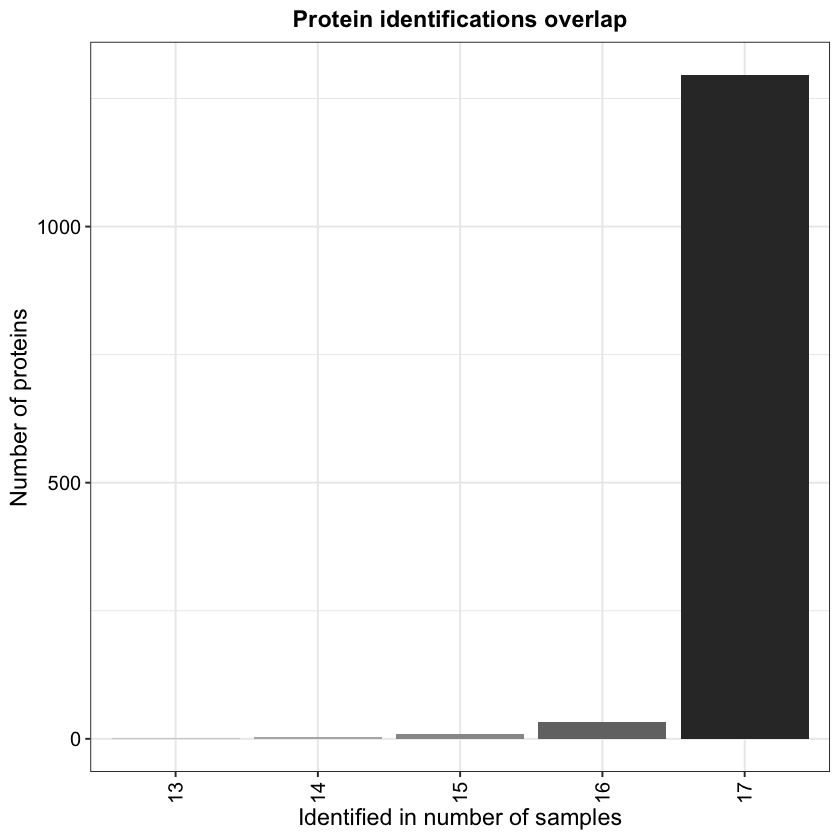

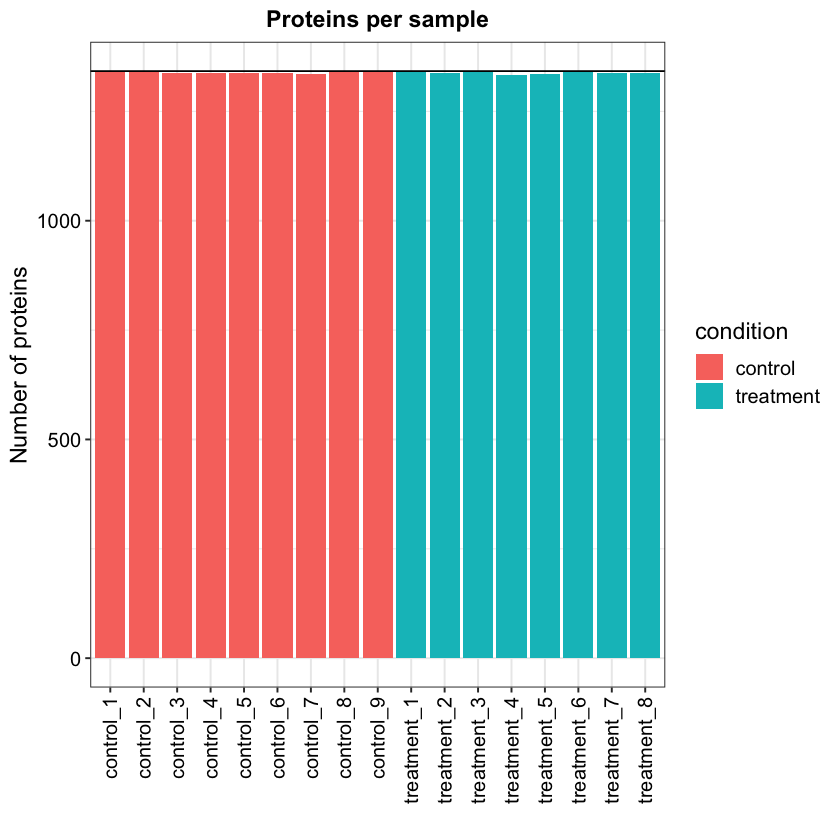

In [20]:
df1 <- read.csv('Census/SLine-ChatMouse-RawIntensityTable-95.txt')
row.names(df1) <- df1[,1]

# Generate experimental design
experimental_design <- data_frame(label = colnames(df1)[!colnames(df1) %in% c("ClusterID")], condition = c("control","control","control","control","control","control","control","control","control","treatment","treatment","treatment","treatment","treatment","treatment","treatment","treatment"), replicate=c(1,2,3,4,5,6,7,8,9,1,2,3,4,5,6,7,8))
experimental_design$replicate <- as.integer(experimental_design$replicate)

controls <- c(2,3,4,5,6,7,8,9,10)
controls <- as.integer(controls)
treatments <- c(11,12,13,14,15,16,17,18)
treatments <- as.integer(treatments)

# Generate a SummarizedExperiment object
df1_unique_names <- make_unique(df1, "ClusterID", 'ClusterID', delim=';')
se <- make_se(df1_unique_names, c(controls, treatments), experimental_design)

se

# Plot a barplot of the protein quantification overlap between samples
plot_frequency(se)
plot_numbers(se)

# filter proteins for number of entries
filtered_1 <- filter_proteins(se, "fraction", min=0.35)

# plot protein frequencies again
plot_frequency(filtered_1)
plot_numbers(filtered_1)

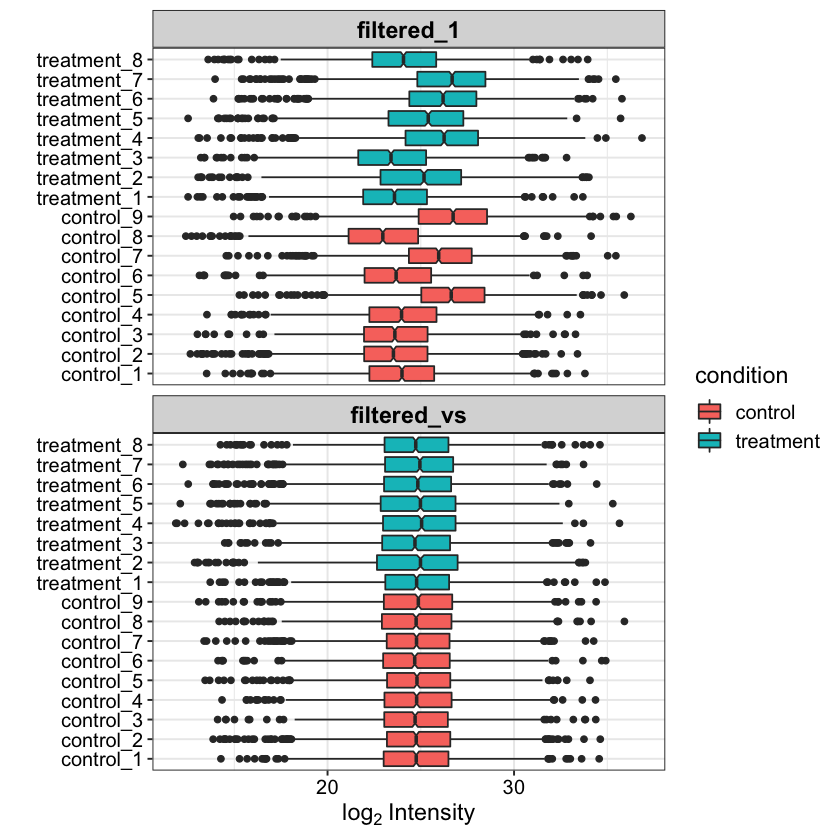

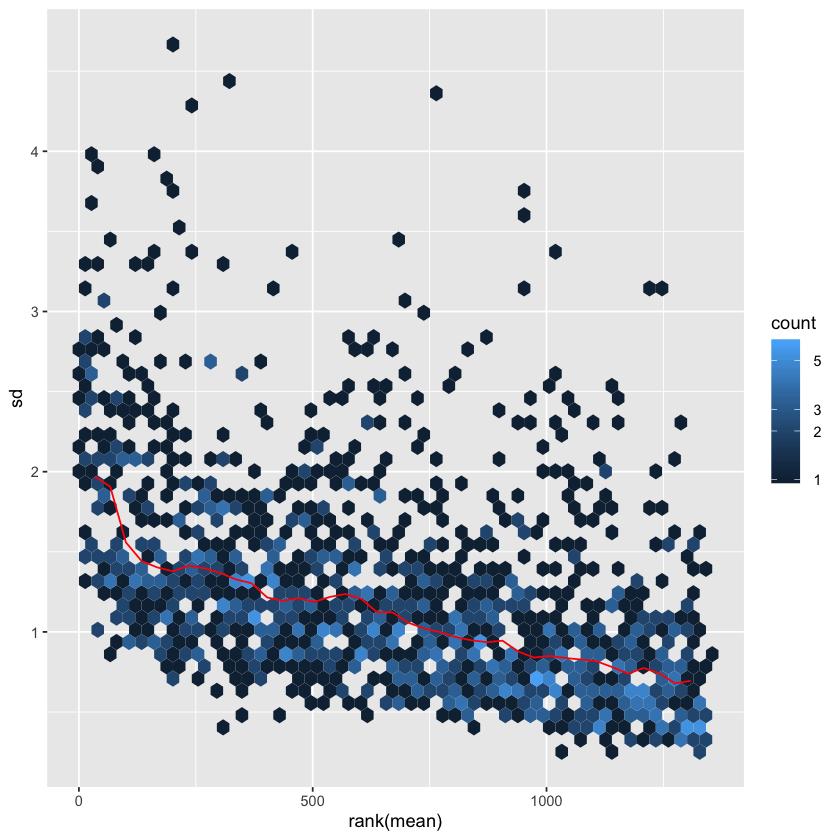

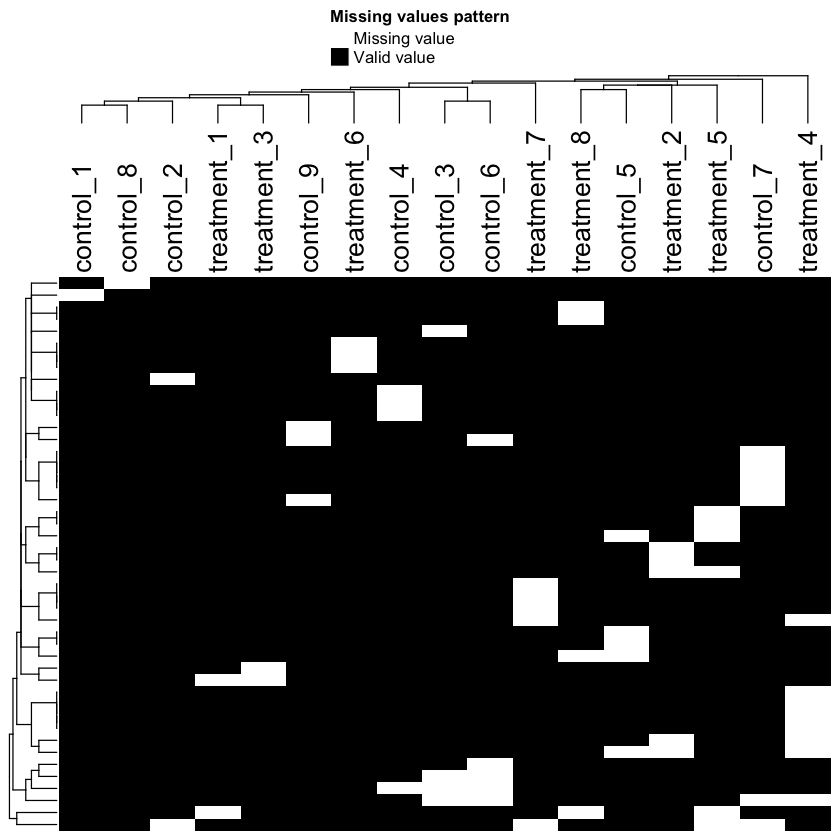

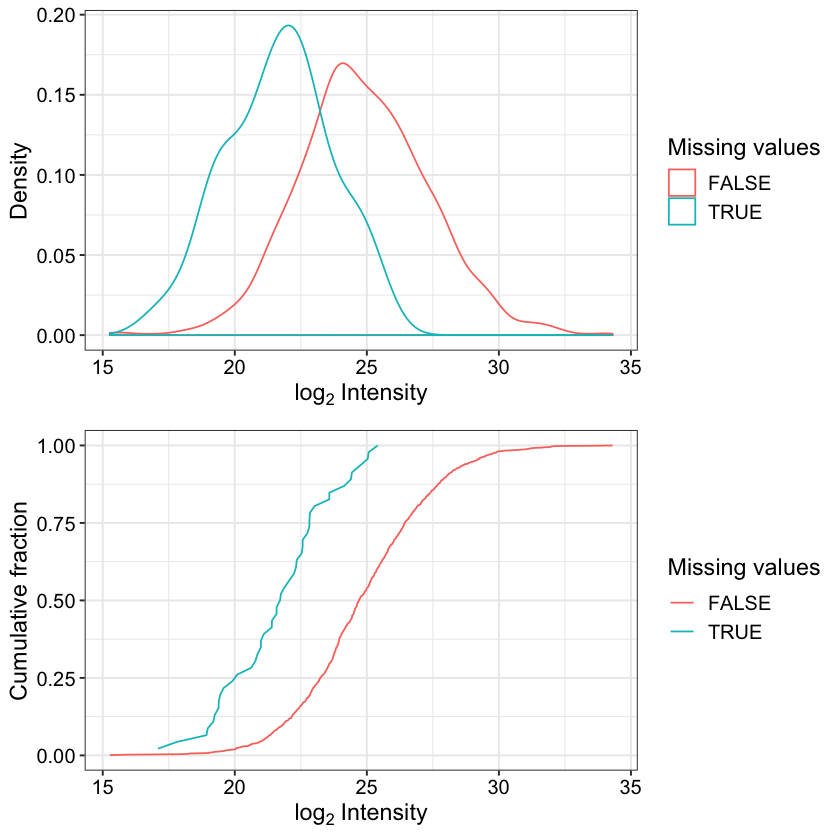

In [21]:
# Scale and variance stabilize
filtered_vs <- normalize_vsn(filtered_1)

# Normalization plots
plot_normalization(filtered_1, filtered_vs)

# Mean versus Sd plot
meanSdPlot(filtered_vs)

# Plot a heatmap of proteins with missing values
plot_missval(filtered_vs)

# Plot intensity distributions and cumulative fraction of proteins 
# with and without missing values
plot_detect(filtered_vs)

Iterations of EM: 
1...2...3...4...
Iterations of EM: 
1...2...3...4...


class: SummarizedExperiment 
dim: 1342 17 
metadata(0):
assays(1): ''
rownames(1342): 10010 10011 ... 9956 9997
rowData names(3): ClusterID name ID
colnames(17): control_1 control_2 ... treatment_7 treatment_8
colData names(4): label ID condition replicate

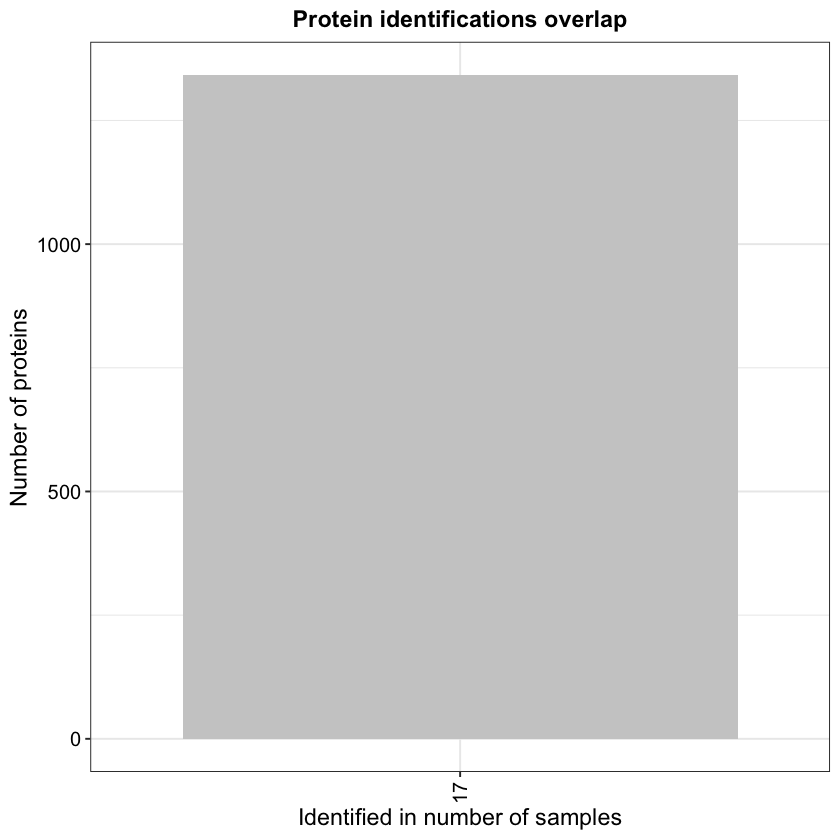

In [22]:
# Extract protein names with missing values 
# in all replicates of at least one condition
proteins_MNAR_control <- get_df_long(filtered_vs[,1:9]) %>%
  group_by(name, condition) %>%
  summarize(NAs = all(is.na(intensity))) %>% 
  filter(NAs) %>% 
  pull(name) %>% 
  unique()

# Extract protein names with missing values 
# in all replicates of at least one condition
proteins_MNAR_treated <- get_df_long(filtered_vs[,10:17]) %>%
  group_by(name, condition) %>%
  summarize(NAs = all(is.na(intensity))) %>% 
  filter(NAs) %>% 
  pull(name) %>% 
  unique()

# Get a logical vector
MNAR_control <- names(filtered_vs) %in% proteins_MNAR_control
MNAR_treated <- names(filtered_vs) %in% proteins_MNAR_treated

# Perform a mixed imputation
mixed_imputation_control <- impute(
  filtered_vs[,1:9], 
  fun = "mixed",
  randna = !MNAR_control, # we have to define MAR which is the opposite of MNAR
  mar = "MLE", # imputation function for MAR
  mnar = "zero") # imputation function for MNAR

# Perform a mixed imputation
mixed_imputation_treated <- impute(
  filtered_vs[,10:17], 
  fun = "mixed",
  randna = !MNAR_treated, # we have to define MAR which is the opposite of MNAR
  mar = "MLE", # imputation function for MAR
  mnar = "zero") # imputation function for MNAR

round_df <- function(x, digits) {
    # round all numeric variables
    # x: data frame 
    # digits: number of digits to round
    numeric_columns <- sapply(x, mode) == 'numeric'
    x[numeric_columns] <-  round(x[numeric_columns], digits)
    x
}

mixed_imp_combined <- cbind(assay(mixed_imputation_control), assay(mixed_imputation_treated))
mixed_imp_combined <- 2^(mixed_imp_combined)
mixed_imp_combined <- round_df(mixed_imp_combined, 0)
#mixed_imp_combined

df2 = as.data.frame.matrix(mixed_imp_combined) 
df2 <- cbind(ClusterID = rownames(df2), df2)

# Generate experimental design
experimental_design <- data_frame(label = colnames(df2)[!colnames(df2) %in% c("ClusterID")], condition = c("control","control","control","control","control","control","control","control","control","treatment","treatment","treatment","treatment","treatment","treatment","treatment","treatment"), replicate=c(1,2,3,4,5,6,7,8,9,1,2,3,4,5,6,7,8))
experimental_design$replicate <- as.integer(experimental_design$replicate)

controls <- c(2,3,4,5,6,7,8,9,10)
controls <- as.integer(controls)
treatments <- c(11,12,13,14,15,16,17,18)
treatments <- as.integer(treatments)

# Generate a SummarizedExperiment object
df2_unique_names <- make_unique(df2, "ClusterID", "ClusterID", delim=';')
se2 <- make_se(df2_unique_names, c(controls, treatments), experimental_design)

se2

# Plot a barplot of the protein quantification overlap between samples
plot_frequency(se2)

In [23]:
# Function that wraps around test_diff, add_rejections and get_results functions
DE_analysis <- function(se) {
  se %>% 
    test_diff(., type = "control", control = "control") %>%
    add_rejections(., alpha = 0.2, lfc = 0)
}

# Function to extract number of DE proteins
DE_prots <- function(results) {
  data_frame(Dataset = gsub("_results", "", results),
    significant_proteins = get(results) %>% 
      filter(significant) %>% 
      nrow())
}

#differential expression analysis
analysis_1 <- DE_analysis(se2)
res_1 <- analysis_1 %>% get_results()

# Number of significant proteins
map_df(c("res_1"), DE_prots)

Tested contrasts: treatment_vs_control



Dataset,significant_proteins
<chr>,<int>
res_1,0


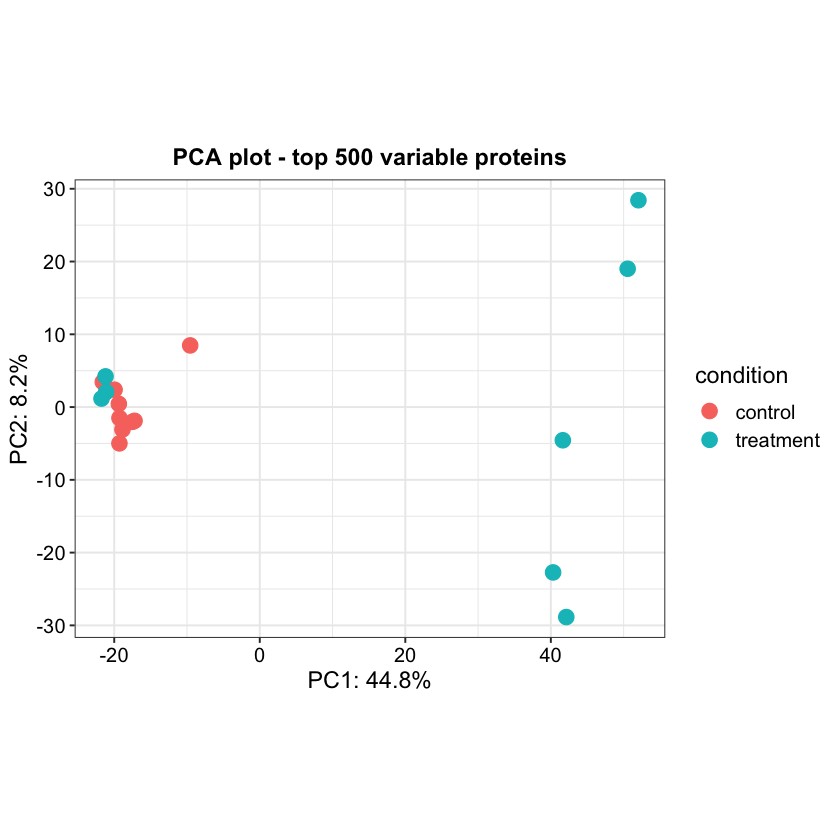

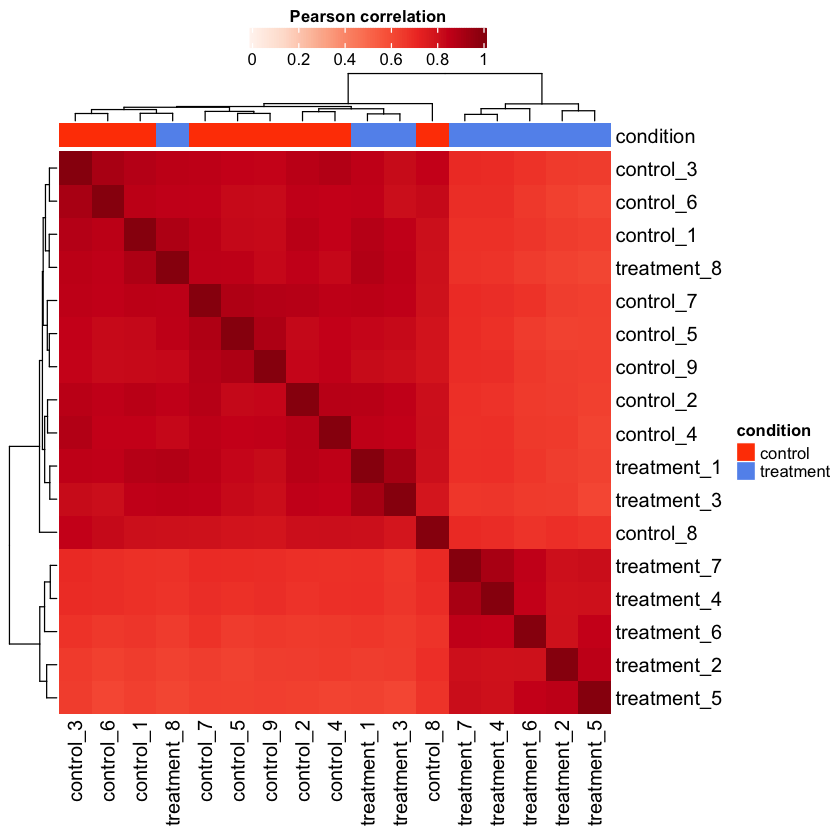

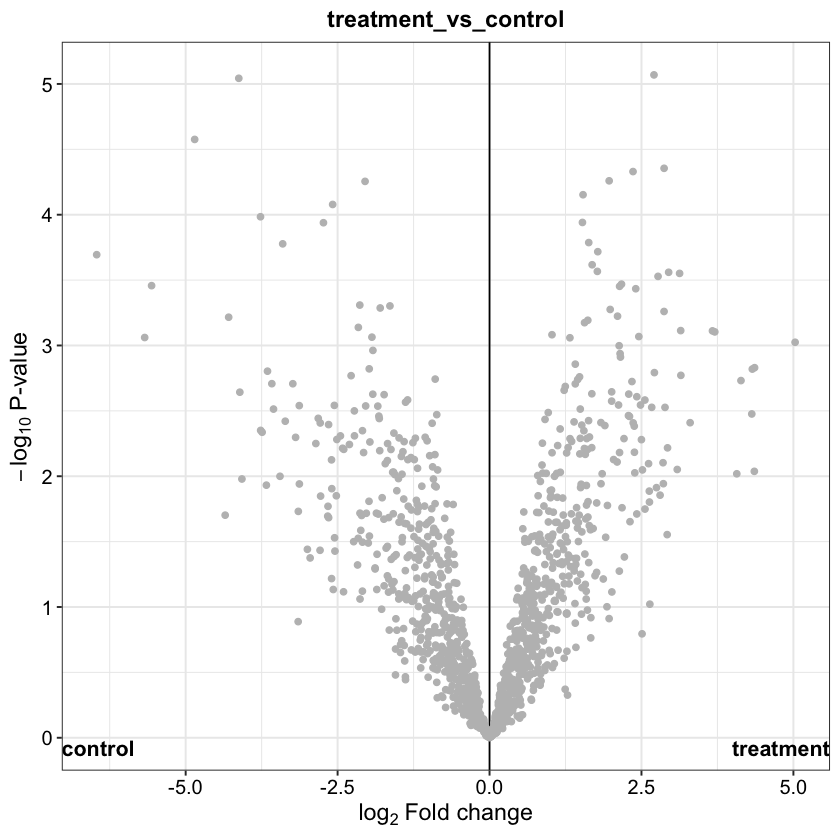

In [24]:
# Plot PCA
plot_pca(analysis_1, x = 1, y = 2, n = 500, point_size = 4, label = FALSE, indicate = c('condition'))

# Plot the Pearson correlation matrix
plot_cor(analysis_1, significant = FALSE, lower = 0, upper = 1, pal = "Reds", indicate = c('condition'))

# Plot Volcano
plot_volcano(analysis_1, contrast = "treatment_vs_control", label_size = 2, add_names = FALSE)

In [29]:
#show raw and final transformed value of protein
show_values <- function(row_num1) {
    log_transformed_value <- assay(se2)[rownames(assay(se2)) == row_num1]
    raw_value <- (2^assay(se)[rownames(assay(se)) == row_num1])
    raw_value[is.na(raw_value)] <- 0
    var3 <- cbind(raw_value, log_transformed_value)
    var3
}

show_values(21023)

raw_value,log_transformed_value
118147814,27.58018
133961371,28.21836
165124932,28.38458
180134907,28.23329
1168390941,28.28461
200504722,28.57607
554313678,27.85720
76529904,27.97593
1068409530,28.12722
338312309,29.52073


In [25]:
res_1[order(as.numeric(res_1$treatment_vs_control_p.val)),]
#res_1[0:50,]

,name,ID,treatment_vs_control_p.val,treatment_vs_control_p.adj,significant,treatment_vs_control_significant,treatment_vs_control_ratio,control_centered,treatment_centered
,<chr>,<chr>,<dbl>,<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
1282,8908,8908,8.525576e-06,1,FALSE,FALSE,2.71,-1.270,1.430
1005,336,336,9.051113e-06,1,FALSE,FALSE,-4.13,1.940,-2.180
1081,4661,4661,2.656275e-05,1,FALSE,FALSE,-4.85,2.280,-2.570
1321,9488,9488,4.416424e-05,1,FALSE,FALSE,2.87,-1.350,1.520
1157,6284,6284,4.678083e-05,1,FALSE,FALSE,2.36,-1.110,1.250
74,11388,11388,5.505243e-05,1,FALSE,FALSE,1.97,-0.926,1.040
859,30574,30574,5.559730e-05,1,FALSE,FALSE,-2.05,0.964,-1.080
155,12777,12777,7.034862e-05,1,FALSE,FALSE,1.54,-0.724,0.814
1275,88,88,8.349209e-05,1,FALSE,FALSE,-2.58,1.210,-1.370


In [110]:
df_wide <- get_df_wide(analysis_1)
df_wide

name,control_1,control_2,control_3,control_4,control_5,control_6,control_7,control_8,control_9,⋯,treatment_8,ClusterID,ID,treatment_vs_control_CI.L,treatment_vs_control_CI.R,treatment_vs_control_diff,treatment_vs_control_p.adj,treatment_vs_control_p.val,significant,treatment_vs_control_significant
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
0,22.86470,22.55164,24.18740,23.79771,23.96599,25.42366,22.61707,22.47633,24.56640,⋯,26.01328,0,0,0.905391297,3.01534595,1.96036862,0.4530606,0.0007930918,FALSE,FALSE
10029,20.63465,22.00318,20.86346,22.71803,21.98656,20.96056,20.31160,19.09798,23.34660,⋯,23.95984,10029,10029,1.239433998,3.67018277,2.45480838,0.3708870,0.0003407574,FALSE,FALSE
10070,21.92450,22.15958,22.94141,21.43463,21.95596,20.43133,21.57807,23.20234,19.54950,⋯,22.58795,10070,10070,-1.192636320,1.22106417,0.01421392,0.9555830,0.9808142453,FALSE,FALSE
10123,19.97446,20.84359,20.38580,22.80173,21.12497,19.03492,21.44206,22.51466,21.53272,⋯,21.49946,10123,10123,-2.192361414,0.48581312,-0.85327415,0.9118971,0.2009775807,FALSE,FALSE
10135,24.45362,21.87969,23.85125,25.72238,24.78042,25.21768,25.12585,26.62714,24.68863,⋯,25.25290,10135,10135,-0.731196290,1.64910269,0.45895320,0.9354250,0.4340218421,FALSE,FALSE
102,22.59966,22.64170,21.54343,22.82495,21.87846,21.51221,22.87801,22.05050,23.99494,⋯,21.77360,102,102,-1.615049544,0.68759459,-0.46372748,0.9341408,0.4141281574,FALSE,FALSE
10256,20.53135,18.24380,23.13383,19.59246,21.94885,21.10918,20.48756,19.75309,18.83855,⋯,17.80771,10256,10256,-1.069510338,1.88771098,0.40910032,0.9427215,0.5733986478,FALSE,FALSE
10282,25.62179,26.13802,24.66294,26.04366,25.41907,25.47956,26.11299,27.80466,26.35497,⋯,25.83954,10282,10282,-1.405176739,1.11542239,-0.14487718,0.9512626,0.8145319616,FALSE,FALSE
104,28.37036,26.18854,26.08805,29.18134,27.59686,27.14778,29.05094,28.88726,27.31986,⋯,27.36239,104,104,-0.987538746,1.21223830,0.11234978,0.9518416,0.8348604152,FALSE,FALSE


In [111]:
# Save analyzed data
save(se, filtered_vs, se2, analysis_1, file = "Census-DEP-ChatMB-95.RData")

write.csv(df_wide, "Census-DEP-ChatMB-95.csv")

In [44]:
#load("data.RData")

In [27]:
#assay(filtered_vs)
#assay(mixed_imputation_control)
#assay(mixed_imputation_treated)
mixed_imp_combined

,control_1,control_2,control_3,control_4,control_5,control_6,control_7,control_8,control_9,treatment_1,treatment_2,treatment_3,treatment_4,treatment_5,treatment_6,treatment_7,treatment_8
0,20.80904,22.35680,21.31339,20.59143,23.57340,21.31586,22.61707,22.47633,20.76586,25.76917,24.48303,24.39276,25.37043,25.27360,25.38250,25.14611,26.87379
10029,21.08980,22.99312,20.86346,22.71803,21.98656,20.61022,20.77295,20.72898,23.34660,22.67484,22.07139,23.54922,20.23877,24.72740,22.30048,22.73759,25.34474
10070,21.92450,22.15958,22.94141,21.43463,21.95596,20.43133,21.57807,21.73631,19.54950,20.65766,21.29192,21.90786,19.38609,23.93871,21.00686,20.43860,22.58795
10123,19.97446,20.97870,20.38580,22.87906,22.14347,21.27160,21.44206,22.40602,21.53272,19.61523,21.84289,23.66670,23.87090,23.35945,20.39909,21.65070,21.85329
10135,24.45362,21.87969,23.85125,25.72238,24.78042,25.21768,25.12585,26.62714,24.68863,24.60787,24.58642,25.66222,26.48377,25.67267,23.55259,25.49467,25.25290
102,22.59966,26.23116,21.04170,22.82495,23.85800,21.51221,22.87801,22.17736,23.99494,23.96580,22.07787,22.64483,22.68336,24.21384,26.45646,23.37639,21.77360
10256,20.53135,22.92812,20.38754,19.59245,21.94885,21.10918,20.48756,21.86149,22.17880,20.12697,20.58074,21.50306,25.17253,19.86825,23.81569,20.87134,21.40578
10282,25.62179,26.13802,24.66294,26.04366,25.41907,25.47956,26.11299,23.04627,26.35497,26.42511,26.53026,25.37284,27.98858,22.85696,27.01569,24.48993,25.83954
104,28.37036,26.18854,26.08805,29.18134,27.59686,27.14778,29.05094,28.88726,27.31986,27.41009,27.04877,28.29352,28.26028,27.16881,28.69542,28.73150,27.36239
10460,19.87473,19.75631,21.07572,16.42880,19.51493,20.42096,18.64315,20.96159,18.10759,22.33561,22.76827,21.68212,18.77311,18.09084,16.74255,17.37752,22.66963


In [28]:
df2

,ClusterID,control_1,control_2,control_3,control_4,control_5,control_6,control_7,control_8,control_9,treatment_1,treatment_2,treatment_3,treatment_4,treatment_5,treatment_6,treatment_7,treatment_8
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,0,20.80904,22.35680,21.31339,20.59143,23.57340,21.31586,22.61707,22.47633,20.76586,25.76917,24.48303,24.39276,25.37043,25.27360,25.38250,25.14611,26.87379
10029,10029,21.08980,22.99312,20.86346,22.71803,21.98656,20.61022,20.77295,20.72898,23.34660,22.67484,22.07139,23.54922,20.23877,24.72740,22.30048,22.73759,25.34474
10070,10070,21.92450,22.15958,22.94141,21.43463,21.95596,20.43133,21.57807,21.73631,19.54950,20.65766,21.29192,21.90786,19.38609,23.93871,21.00686,20.43860,22.58795
10123,10123,19.97446,20.97870,20.38580,22.87906,22.14347,21.27160,21.44206,22.40602,21.53272,19.61523,21.84289,23.66670,23.87090,23.35945,20.39909,21.65070,21.85329
10135,10135,24.45362,21.87969,23.85125,25.72238,24.78042,25.21768,25.12585,26.62714,24.68863,24.60787,24.58642,25.66222,26.48377,25.67267,23.55259,25.49467,25.25290
102,102,22.59966,26.23116,21.04170,22.82495,23.85800,21.51221,22.87801,22.17736,23.99494,23.96580,22.07787,22.64483,22.68336,24.21384,26.45646,23.37639,21.77360
10256,10256,20.53135,22.92812,20.38754,19.59245,21.94885,21.10918,20.48756,21.86149,22.17880,20.12697,20.58074,21.50306,25.17253,19.86825,23.81569,20.87134,21.40578
10282,10282,25.62179,26.13802,24.66294,26.04366,25.41907,25.47956,26.11299,23.04627,26.35497,26.42511,26.53026,25.37284,27.98858,22.85696,27.01569,24.48993,25.83954
104,104,28.37036,26.18854,26.08805,29.18134,27.59686,27.14778,29.05094,28.88726,27.31986,27.41009,27.04877,28.29352,28.26028,27.16881,28.69542,28.73150,27.36239
